---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../database/apples_pears.csv")

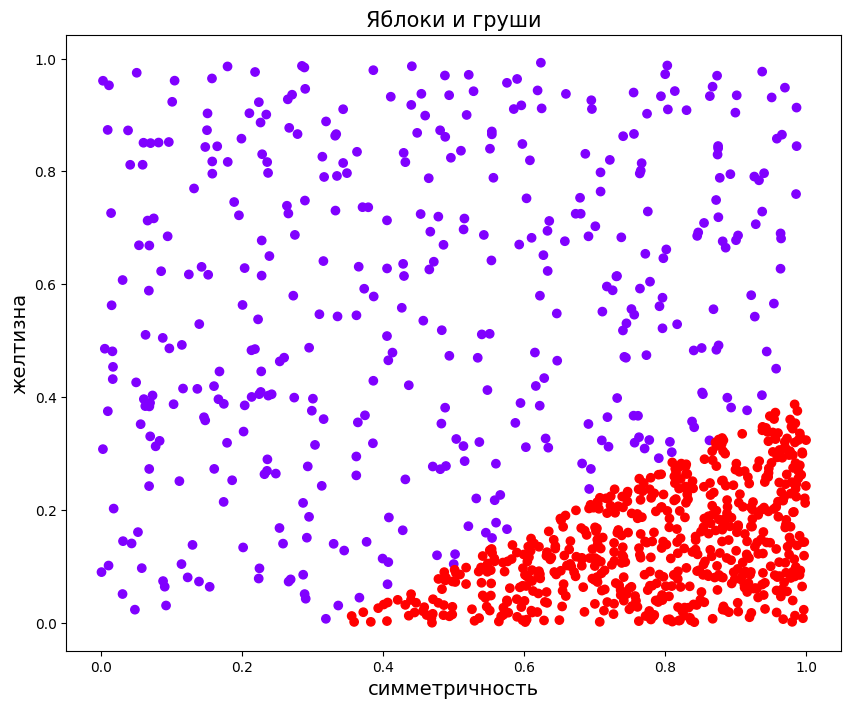

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [4]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [5]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [6]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [85]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [86]:
neuron(torch.FloatTensor([1, 1]))

tensor([0.3340], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

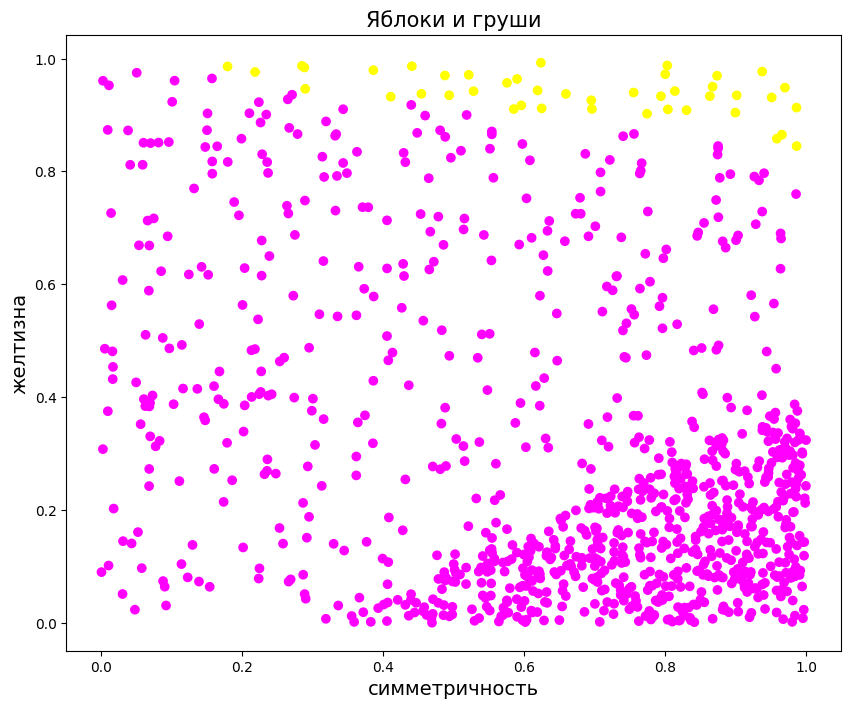

In [7]:
proba_pred = neuron(torch.FloatTensor(X))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы:

In [8]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

Код обучения одного нейрона на PyTorch:

In [9]:
# квадратичная функция потерь (можно сделать другую, например, LogLoss)
loss_fn = torch.nn.MSELoss(reduction='sum')

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(50000):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print(f'{t} {loss.data}')

    # обнуляем градиенты перед backard_pass'ом (обязательно!)
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

0 303.13037109375
1 287.95855712890625
2 275.5055236816406
3 265.4142761230469
4 257.1987609863281
5 250.3892059326172
6 244.59808349609375
7 239.53274536132812
8 234.98306274414062
9 230.8029022216797
10 226.89248657226562
11 223.1846160888672
12 219.63449096679688
13 216.2124786376953
14 212.89915466308594
15 209.68186950683594
16 206.55235290527344
17 203.5052490234375
18 200.5369873046875
19 197.6450653076172
20 194.8275909423828
21 192.0831298828125
22 189.4102783203125
23 186.8077392578125
24 184.27423095703125
25 181.8083953857422
26 179.40882873535156
27 177.0740203857422
28 174.802490234375
29 172.5926513671875
30 170.44293212890625
31 168.35169982910156
32 166.3173370361328
33 164.33824157714844
34 162.4127197265625
35 160.53924560546875
36 158.7161865234375
37 156.94198608398438
38 155.21510314941406
39 153.5340576171875
40 151.89735412597656
41 150.3035430908203
42 148.75128173828125
43 147.23916625976562
44 145.76588439941406
45 144.33018493652344
46 142.93081665039062
47 

Обучили. Предскажем теперь:

Accuracy: 98.8%


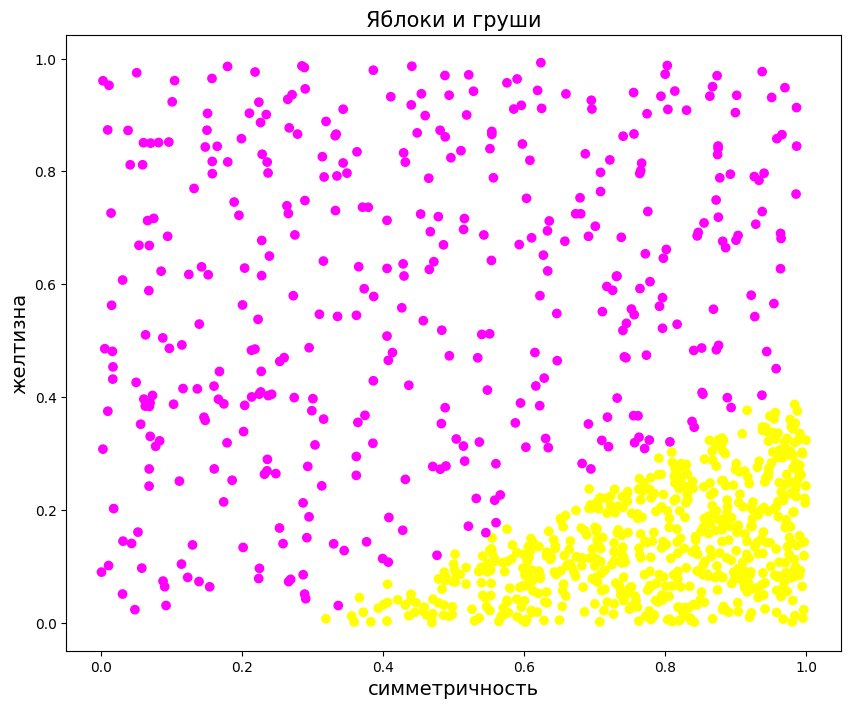

In [10]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
# y_pred = y_pred.data.numpy().reshape(-1)

correct = (y_pred == y).float().sum().item()
accuracy = 100 * correct / len(y)
print(f"Accuracy: {accuracy}%")

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()` или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

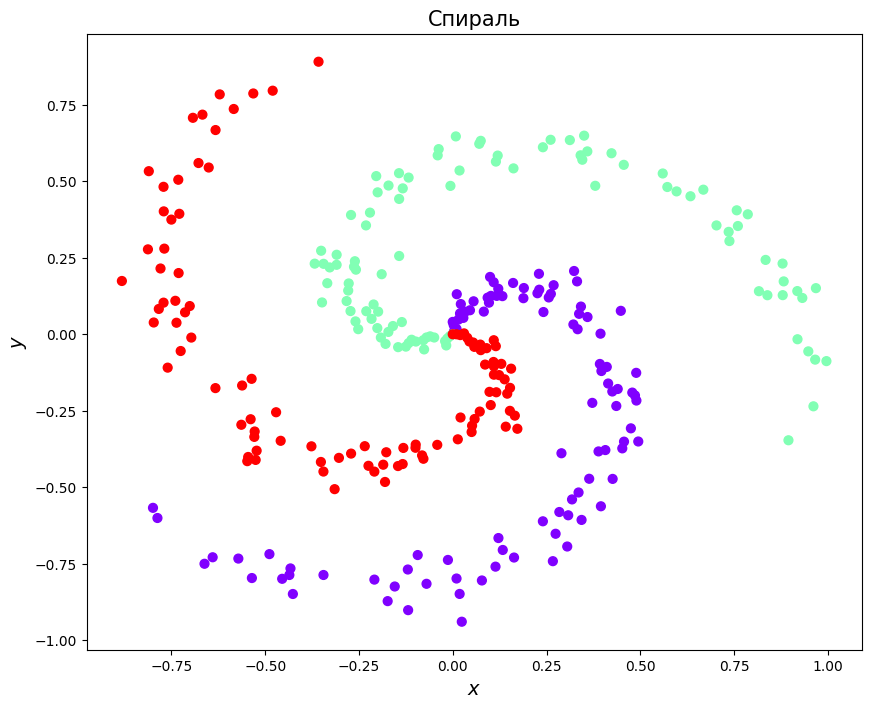

In [124]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [125]:
X = torch.FloatTensor(X)
y = torch.tensor(y)

In [113]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем однослойный перцептрон на линейно неразделимой выборке:

In [143]:
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
D_in, D_out = 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)
print(neuron)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)


In [144]:
y_pred = neuron(X)
y_pred

tensor([[0.1631, 0.4934, 0.5452],
        [0.1621, 0.4918, 0.5397],
        [0.1613, 0.4918, 0.5343],
        [0.1599, 0.4859, 0.5292],
        [0.1587, 0.4823, 0.5245],
        [0.1581, 0.4849, 0.5177],
        [0.1576, 0.4875, 0.5125],
        [0.1560, 0.4808, 0.5067],
        [0.1555, 0.4835, 0.5013],
        [0.1551, 0.4861, 0.4965],
        [0.1527, 0.4730, 0.4906],
        [0.1559, 0.4987, 0.4919],
        [0.1520, 0.4810, 0.4797],
        [0.1491, 0.4608, 0.4761],
        [0.1529, 0.4950, 0.4744],
        [0.1511, 0.4894, 0.4667],
        [0.1505, 0.4905, 0.4620],
        [0.1507, 0.4953, 0.4592],
        [0.1509, 0.5002, 0.4568],
        [0.1482, 0.4902, 0.4465],
        [0.1458, 0.4805, 0.4379],
        [0.1438, 0.4728, 0.4308],
        [0.1522, 0.5194, 0.4499],
        [0.1465, 0.4972, 0.4295],
        [0.1486, 0.5106, 0.4326],
        [0.1575, 0.5483, 0.4631],
        [0.1508, 0.5265, 0.4347],
        [0.1496, 0.5248, 0.4279],
        [0.1525, 0.5397, 0.4361],
        [0.151

In [145]:
# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

learning_rate = 1e-3
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(50000):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print(f'{t} {loss.data}')

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

0 329.1758117675781
1 325.9479675292969
2 322.9197998046875
3 320.0704040527344
4 317.3815002441406
5 314.83685302734375
6 312.42218017578125
7 310.12530517578125
8 307.9350891113281
9 305.8424072265625
10 303.83880615234375
11 301.9172058105469
12 300.0713195800781
13 298.295654296875
14 296.5852966308594
15 294.9360656738281
16 293.3441467285156
17 291.80621337890625
18 290.3192138671875
19 288.88043212890625
20 287.4874572753906
21 286.13812255859375
22 284.8302307128906
23 283.5620422363281
24 282.331787109375
25 281.1379699707031
26 279.9789733886719
27 278.85345458984375
28 277.76007080078125
29 276.69769287109375
30 275.6650695800781
31 274.6611633300781
32 273.6849365234375
33 272.73529052734375
34 271.81146240234375
35 270.9124450683594
36 270.0373840332031
37 269.185546875
38 268.3560485839844
39 267.54815673828125
40 266.7612609863281
41 265.9945373535156
42 265.2474060058594
43 264.51922607421875
44 263.809326171875
45 263.11724853515625
46 262.4422912597656
47 261.78405761

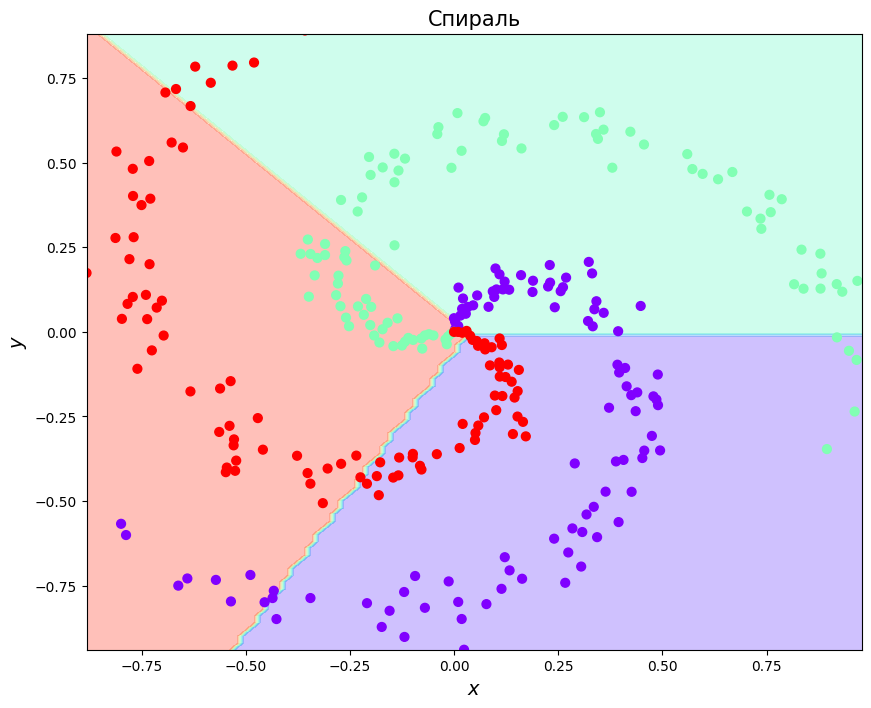

In [146]:
h = 0.02
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(grid_tensor)
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слишком впечатляет. Попробуем многослойную нейросеть на этой же задаче.

In [147]:
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
D_in, D_out = 2, 3
h1 = 200
h2 = 100

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, h1),
    Sigmoid(),
    torch.nn.Linear(h1, h2),
    Sigmoid(),
    torch.nn.Linear(h2, D_out),
)
print(neuron)

Sequential(
  (0): Linear(in_features=2, out_features=200, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=200, out_features=100, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=100, out_features=3, bias=True)
)


In [148]:
# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')

learning_rate = 1e-3
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(50000):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print(f'{t} {loss.data}')

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

0 335.2843322753906
1 347.2692565917969
2 366.73077392578125
3 426.9631652832031
4 383.9423828125
5 442.8034362792969
6 362.16961669921875
7 391.34381103515625
8 362.4540710449219
9 383.5013732910156
10 355.376220703125
11 367.37725830078125
12 349.4090576171875
13 356.033203125
14 344.22991943359375
15 347.683349609375
16 339.94525146484375
17 341.6024169921875
18 336.520263671875
19 337.1993713378906
20 333.83978271484375
21 334.0096740722656
22 331.7628479003906
23 331.6827697753906
24 330.1541442871094
25 329.9620361328125
26 328.8975830078125
27 328.6635437011719
28 327.90008544921875
29 327.6572265625
30 327.08953857421875
31 326.85198974609375
32 326.4122314453125
33 326.1842041015625
34 325.828125
35 325.6095886230469
36 325.3080749511719
37 325.0972595214844
38 324.8311462402344
39 324.62548828125
40 324.3818664550781
41 324.1790771484375
42 323.94915771484375
43 323.7471618652344
44 323.5249938964844
45 323.3219299316406
46 323.1031799316406
47 322.8976135253906
48 322.679351

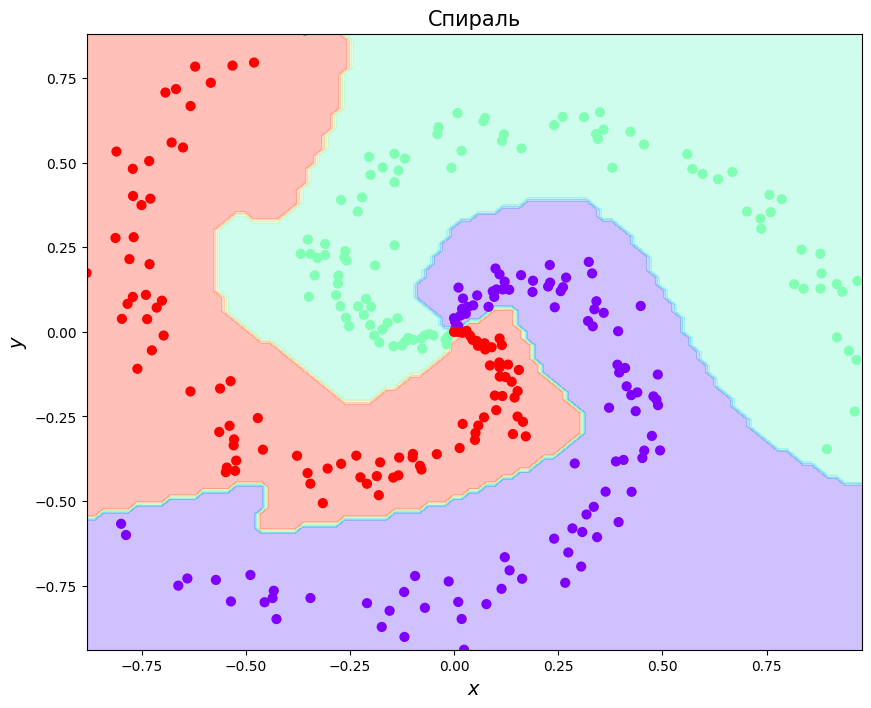

In [149]:
h = 0.02
x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(grid_tensor)
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*